# 📊 Stock Price Prediction with PCA-LSTM

## Project Overview
This notebook demonstrates the application of **Principal Component Analysis (PCA)** combined with **Long Short-Term Memory (LSTM)** networks for stock price prediction. We compare the performance of PCA-enhanced models against standard LSTM models to evaluate dimensionality reduction benefits.

### Key Objectives:
1. **Data Preparation**: Load and process Apple (AAPL) stock data with technical indicators
2. **Feature Engineering**: Create 10 technical indicators for model training
3. **Dimensionality Reduction**: Apply PCA to reduce feature space from 10 to 7 dimensions
4. **Model Training**: Train LSTM models with and without PCA
5. **Performance Comparison**: Evaluate MAE, training time, and memory usage
6. **Comprehensive Analysis**: Visualize PCA components, feature importance, and predictions

### Dataset:
- **Stock**: Apple Inc. (AAPL)
- **Period**: January 2015 - January 2023 (8 years)
- **Features**: 10 technical indicators including RSI, MACD, Bollinger Bands, ATR, ADX

---

In [1]:
import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import ta

## Functions & Pipeline
### Core modular functions for PCA and non-PCA workflows:
 - set_global_seeds: Fix random seeds
 - load_stock_data: Get stock data, use cache if available
 - add_technical_indicators: Compute 10 indicators (trend, momentum, volatility, strength)
 - prepare_features: Scale, apply PCA if needed
 - create_sequences: Turn time series into supervised data
 - split_train_test: Train/test split
 - build_lstm_model: 3-layer LSTM, BatchNorm, Dropout, L2, Huber loss
 - get_callbacks: EarlyStopping & ReduceLROnPlateau
 - train_model: Fit and time model
 - invert_scale: Reverse scaler transform
 - plot_loss, plot_predictions: Visuals
 - save_training_metrics: Export metrics
#### Pipeline: load -> engineer -> PCA -> sequence -> split -> train -> predict -> plot

In [ ]:
FEATURES = [
    'Close', 'MA50', 'SMA5', 'RSI', 'MACD',
    'Bollinger_Upper', 'Bollinger_Lower', 'ATR', 'ADX', 'STD10'
]

# Set Global Seeds
def set_global_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)

set_global_seeds(42)

# Stock Data Loader
def load_stock_data(stocks, start_date, end_date, local_file='aapl_daily.csv'):
    if os.path.exists(local_file):
        df = pd.read_csv(local_file)
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    else:
        df = yf.download(stocks, start=start_date, end=end_date)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        df.dropna(inplace=True)
        df['Date'] = df.index
        # Save locally for future use
        df.to_csv(local_file)
    df.dropna(inplace=True)
    df['Date'] = df.index
    return df

stocks = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-01-01'
data = load_stock_data(stocks, start_date, end_date)

# Technical Indicators
def add_technical_indicators(df):
    df['Return'] = df['Close'].pct_change()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['STD10'] = df['Close'].rolling(window=10).std()
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['Bollinger_Upper'] = df['MA10'] + (df['STD10'] * 2)
    df['Bollinger_Lower'] = df['MA10'] - (df['STD10'] * 2)
    df['SMA5'] = df['Close'].rolling(window=5).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # ATR
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift())
    low_close = abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    # ADX
    adx = ta.trend.ADXIndicator(
        high=df['High'].squeeze(),
        low=df['Low'].squeeze(), 
        close=df['Close'].squeeze(),
        window=14
    )
    df['ADX'] = adx.adx()
    df.dropna(inplace=True)
    return df

data = add_technical_indicators(data)

# Feature Preparation
def prepare_features(data, with_pca=True, n_pca_components=7, features=FEATURES):
    scaler = StandardScaler() if with_pca else MinMaxScaler()
    data_scaled = scaler.fit_transform(data[features])

    if with_pca:
        pca = PCA(n_components=n_pca_components)
        data_pca = pca.fit_transform(data_scaled)
        cols = [f'PC{i + 1}' for i in range(n_pca_components)]
        data_df = pd.DataFrame(data_pca, columns=cols)
    else:
        pca = None
        data_pca = None
        data_df = pd.DataFrame(data_scaled, columns=features)

    data_df['Close'] = data['Close'].values
    data_df['Date'] = data['Date'].values
    return data_df, pca, data_pca, scaler, data_scaled

data_pca_df, pca, data_pca, scaler, data_scaled = prepare_features(data, with_pca=True, n_pca_components=7, features=FEATURES)
print(data_pca_df.head())

# Sequence Dataset Preparation
def create_sequences(data, seq_len, label_col='Close', date_col='Date'):
    feature_cols = [col for col in data.columns if col not in [label_col, date_col]]
    X, y, dates = [], [], []
    for i in range(seq_len, len(data)):
        X.append(data.iloc[i-seq_len:i][feature_cols].values)
        y.append(data.iloc[i][label_col])
        dates.append(data.iloc[i][date_col])
    return np.array(X), np.array(y), np.array(dates)

sequence_length = 60
X, y, dates = create_sequences(data_pca_df, sequence_length)

# Train-Test Split
def split_train_test(X, y, dates, test_ratio=0.2, random_state=42):
    return train_test_split(X, y, dates, test_size=test_ratio, random_state=random_state)

X_train, X_test, y_train, y_test, dates_train, dates_test = split_train_test(X, y, dates, 0.2, 42)
dates_test = pd.to_datetime(dates_test)

# Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.keras.losses.Huber(delta=1.0)
    )
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Callbacks
def get_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=0.0001
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    )
    return [early_stopping, reduce_lr]

callbacks = get_callbacks()

# Training
def train_model(model, X_train, y_train, X_val, y_val, callbacks, epochs=150, batch_size=64):
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        shuffle=True
    )
    elapsed = time.time() - start_time
    print(f"Training time: {elapsed:.2f} seconds")
    return history, elapsed

history, pca_training_time = train_model(
    model, X_train, y_train, X_test, y_test, callbacks,
    epochs=150, batch_size=64
)

# Evaluation
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predictions
def invert_scale(scaler, data_flat, features=FEATURES, target_feature='Close'):
    target_idx = features.index(target_feature)
    zeros = np.zeros((data_flat.shape[0], len(features)))
    zeros[:, target_idx] = data_flat.flatten()
    inversed = scaler.inverse_transform(zeros)[:, target_idx]
    return inversed

predictions = model.predict(X_test).flatten()
scaled_predictions = invert_scale(scaler, predictions, FEATURES)
actual_prices = invert_scale(scaler, y_test, FEATURES)

# Sort by date for plotting
sort_idx = np.argsort(dates_test)
dates_test = dates_test[sort_idx]
scaled_predictions = scaled_predictions[sort_idx]
actual_prices = actual_prices[sort_idx]

model.save('pca_lstm_model.keras')

# Save Training Metrics
def save_training_metrics(history, filename='training_metrics.csv'):
    metrics_df = pd.DataFrame({
        'epoch': range(1, len(history.history['loss']) + 1),
        'training_loss': history.history['loss'],
        'validation_loss': history.history['val_loss']
    })
    metrics_df.to_csv(filename, index=False)

save_training_metrics(history, filename='training_metrics.csv')

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.175073 -1.009477  0.128264 -0.899184  0.313580  0.066144  0.018540   
1 -2.208045 -0.593808 -0.201122 -0.400901  0.202422  0.078802  0.012462   
2 -2.203089 -0.621297 -0.252061 -0.435812  0.218349  0.069745  0.018200   
3 -2.201773 -0.551664 -0.332048 -0.336002  0.218187  0.062613  0.011422   
4 -2.179366 -0.819916 -0.381355 -0.544312  0.288890  0.075811  0.012149   

       Close       Date  
0  27.809698 2015-03-16  
1  28.274862 2015-03-17  
2  28.593136 2015-03-18  
3  28.377243 2015-03-19  
4  28.021137 2015-03-20  
Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 69.7611 - val_loss: 72.4402 - learning_rate: 5.0000e-04
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 68.0156 - val_loss: 70.6818 - learning_rate: 5.0000e-04
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 66.7066 - val_loss: 69.0225 - learning_rate: 5.0000e-04
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64m

## 📈 PCA-LSTM Training Results

### Training and Validation Loss & Stock Price Predictions (PCA-LSTM)
- Training loss and validation loss curves are plotted over epochs for convergence and overfitting assessment.
- Actual stock prices and model predictions are shown for the test set (2015-2023) to visually evaluate prediction accuracy and trend following.


### Key Observations:
- **Initial loss**: ~70 (epoch 1)
- **Final training loss**: ~7.16 (epoch 69)
- **Final validation loss**: ~3.59 (epoch 69)
- **Best validation loss**: ~2.33 (epoch 49)
- **Convergence**: Rapid decrease until epoch ~30, then stabilized
- **Model behavior**: Validation loss < training loss indicates good generalization
- **Early stopping**: Triggered around epoch 69 (patience=20)
- **Prediction quality**: Model captures overall trends with close alignment to actual prices

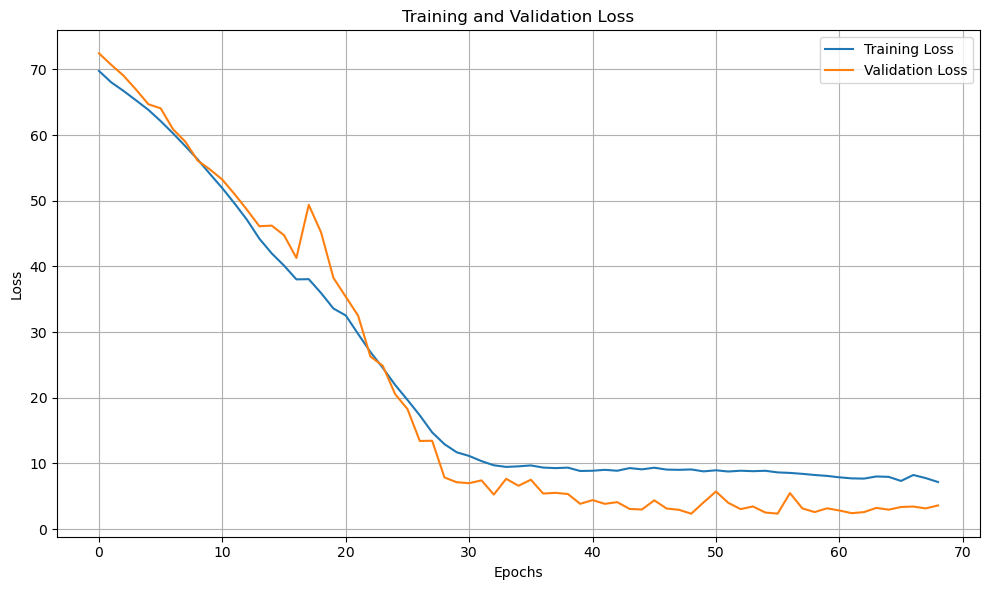

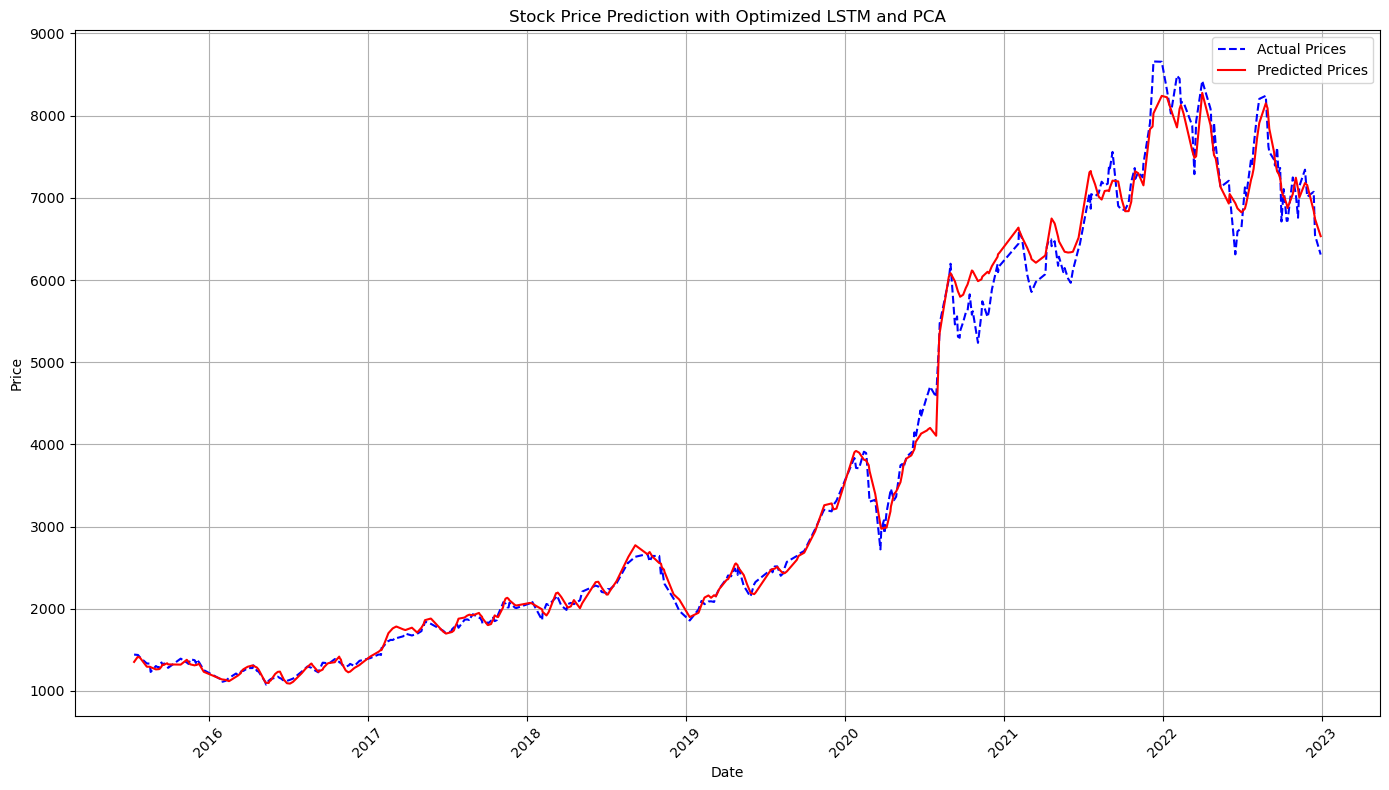

In [6]:
# Plotting loss and predictions
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_predictions(dates, actual_prices, predicted_prices, title='Stock Price Prediction'):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual_prices, label='Actual Prices', color='blue', linestyle='--')
    plt.plot(dates, predicted_prices, label='Predicted Prices', color='red')
    plt.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_loss(history)
plot_predictions(dates_test, actual_prices, scaled_predictions, title="Stock Price Prediction with Optimized LSTM and PCA")


## 📊 4. PCA Explained Variance Analysis

### Component Breakdown:
- **PC1**: 65.39% (dominant price trend component)
- **PC2**: 17.38% (momentum/oscillation patterns)
- **PC1+PC2**: 82% cumulative variance
- **First 3 PCs**: ~92% cumulative variance
- **All 7 PCs**: ~100% cumulative variance

### Key Finding:
First 4 components retain **~96%** of information, validating dimensionality reduction from 10 to 7 features.

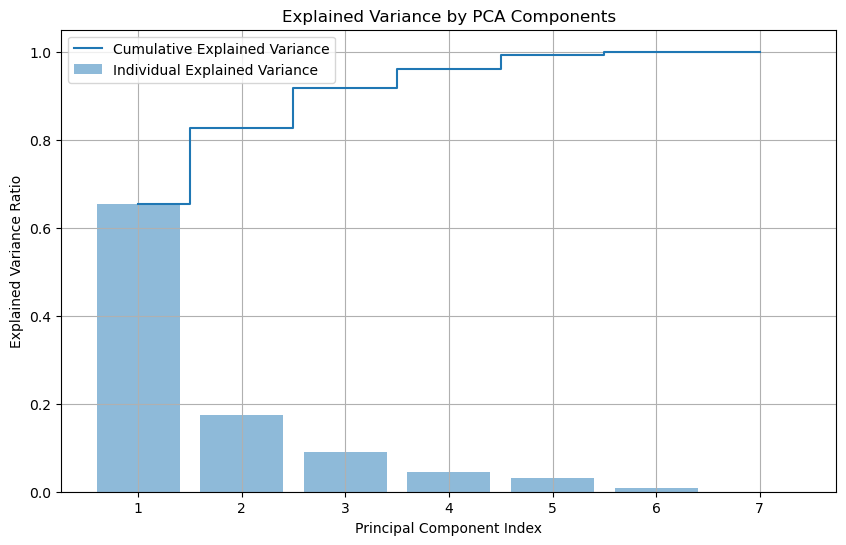

In [14]:
# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.grid()
plt.show()

## PCA Component Visualization

### PC1 vs PC2 Scatter Plot:
- **X-axis**: PC1 (65.39% variance)
- **Y-axis**: PC2 (17.38% variance)
- **Color**: Close price ($20 - $180)

### Three Market Regimes Identified:
1. **Left Cluster (Purple)**: Bear market, tight grouping = low volatility
2. **Middle Cluster (Green)**: Normal trading, wider vertical spread = higher volatility
3. **Right Cluster (Yellow)**: Bull market, wider vertical spread = higher volatility

### Pairwise Plots (6 subplots):
Shows relationships between all PC combinations to validate component independence.

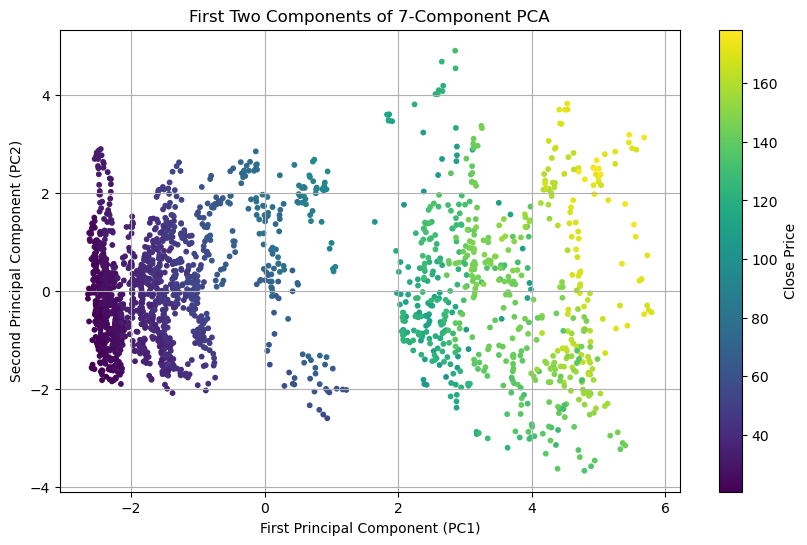

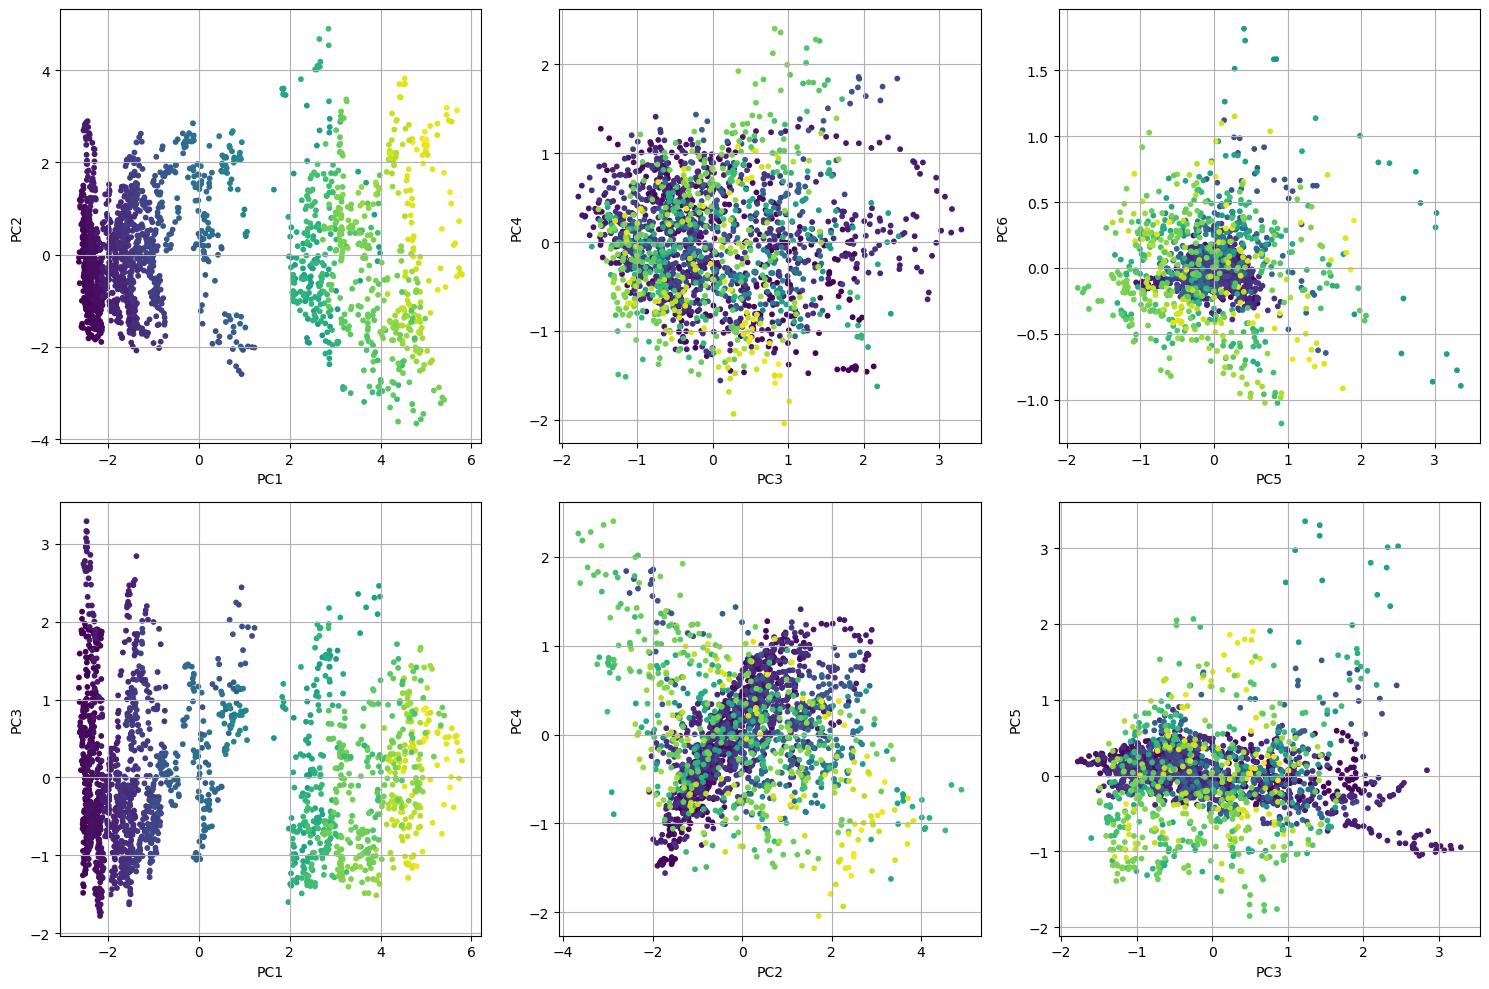

In [8]:
# Visualize PCA-transformed data (first two components)
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['Close'].values, cmap='viridis', s=10)
plt.colorbar(label='Close Price')
plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)') 
plt.title('First Two Components of 7-Component PCA')
plt.grid()
plt.show()

# Visualize all 7 components pairwise
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

component_pairs = [(0,1), (2,3), (4,5), (0,2), (1,3), (2,4)]
for idx, (i,j) in enumerate(component_pairs):
    axes[idx].scatter(data_pca[:, i], data_pca[:, j], 
                     c=data['Close'].values, cmap='viridis', s=10)
    axes[idx].set_xlabel(f'PC{i+1}')
    axes[idx].set_ylabel(f'PC{j+1}')
    axes[idx].grid(True)
plt.tight_layout()
plt.show()

## ⚖️ Model Comparison: WITHOUT PCA

### Setup:
Baseline LSTM trained on **all 10 original features** (no dimensionality reduction) using MinMaxScaler.

### Comparison Metrics:
- **MAE**: Prediction accuracy
- **Training Time**: Computational efficiency  
- **Memory Usage**: Resource consumption

### Key Outputs:
1. **MAE Comparison Bar Chart**: PCA vs No-PCA accuracy
2. **Training Loss Curves**: Convergence behavior
3. **Prediction Plots**: Actual vs predicted prices
4. **Improvement %**: Quantifies PCA benefit

**Goal:** Determine if dimensionality reduction improves model performance.

Training Model WITHOUT PCA
       Close      MA50      SMA5       RSI      MACD  Bollinger_Upper  \
0  27.809698  0.032315  0.042807  0.317949  0.485100         0.046407   
1  28.274862  0.032863  0.043534  0.456006  0.485772         0.045202   
2  28.593136  0.033547  0.045327  0.449959  0.487951         0.045158   
3  28.377243  0.034201  0.046204  0.476010  0.488201         0.045547   
4  28.021137  0.034762  0.046869  0.415440  0.486128         0.045379   

   Bollinger_Lower       ATR       ADX     STD10       Date  
0         0.047515  0.059910  0.256291  0.051240 2015-03-16  
1         0.048106  0.055854  0.231714  0.042494 2015-03-17  
2         0.048132  0.052239  0.221561  0.042159 2015-03-18  
3         0.048042  0.051059  0.212722  0.044507 2015-03-19  
4         0.048013  0.054157  0.186415  0.043813 2015-03-20  
Epoch 1/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 70.4783 - val_loss: 73.5394 - learning_rate: 5.0000e-04
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms

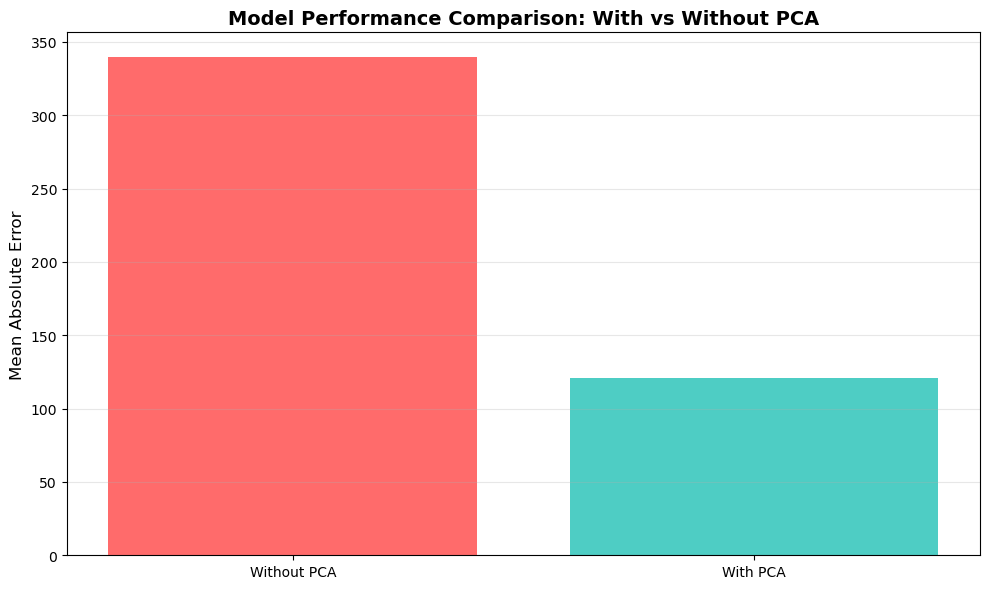

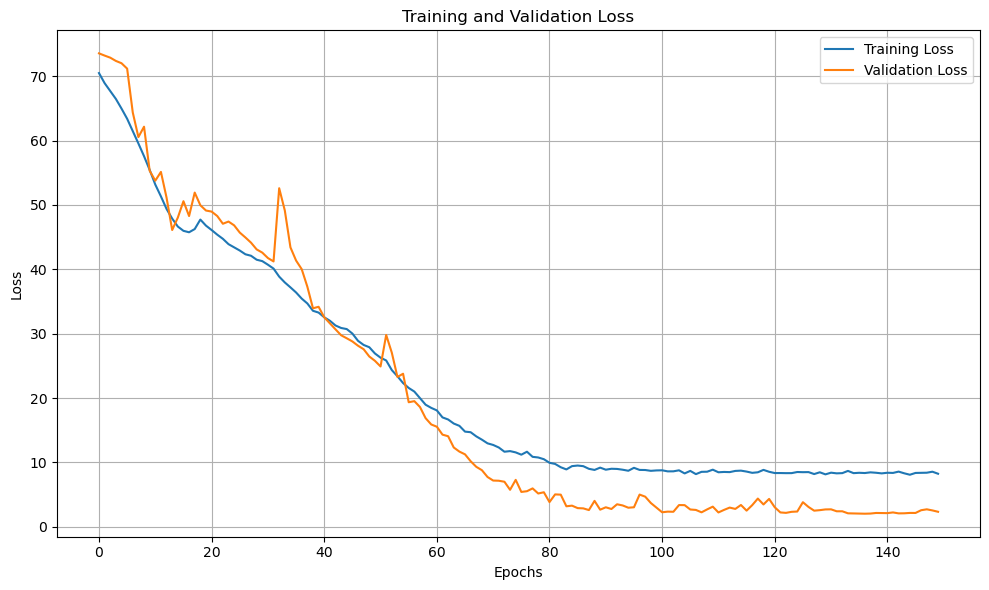

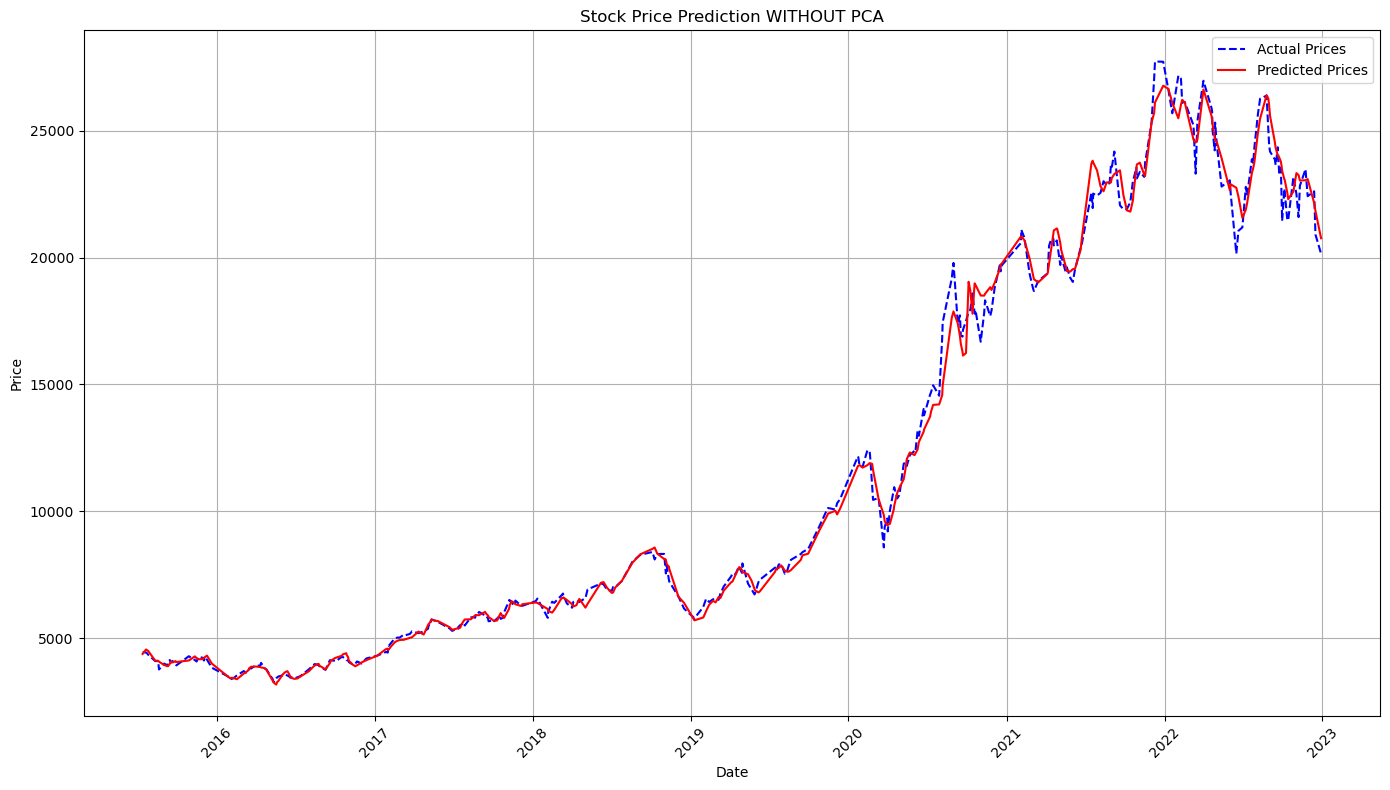

In [ ]:
# Model Comparison: Without PCA
from sklearn.metrics import mean_absolute_error

# Prepare features
print("=" * 60)
print("Training Model WITHOUT PCA")
print("=" * 60)

data_no_pca_df, _, _, scaler_no_pca, data_scaled_no_pca = prepare_features(
    data, 
    with_pca=False, 
    features=FEATURES
)
print(data_no_pca_df.head())

# Create sequences
X_no_pca, y_no_pca, dates_no_pca = create_sequences(data_no_pca_df, sequence_length)

# Train-test split
X_train_no_pca, X_test_no_pca, y_train_no_pca, y_test_no_pca, dates_train_no_pca, dates_test_no_pca = split_train_test(
    X_no_pca, y_no_pca, dates_no_pca, test_ratio=0.2, random_state=42
)
dates_test_no_pca = pd.to_datetime(dates_test_no_pca)

# Build model
model_no_pca = build_lstm_model((X_train_no_pca.shape[1], X_train_no_pca.shape[2]))

# Train model
history_no_pca, no_pca_training_time = train_model(
    model_no_pca, 
    X_train_no_pca, y_train_no_pca, 
    X_test_no_pca, y_test_no_pca, 
    get_callbacks(),
    epochs=150, 
    batch_size=64
)

# Evaluate
loss_no_pca = model_no_pca.evaluate(X_test_no_pca, y_test_no_pca)
print(f"Test Loss (No PCA): {loss_no_pca}")

# Predictions
predictions_no_pca = model_no_pca.predict(X_test_no_pca).flatten()
scaled_predictions_no_pca = invert_scale(scaler_no_pca, predictions_no_pca, FEATURES)
actual_prices_no_pca = invert_scale(scaler_no_pca, y_test_no_pca, FEATURES)

# Sort by date for plotting
sort_idx_no_pca = np.argsort(dates_test_no_pca)
dates_test_no_pca = dates_test_no_pca[sort_idx_no_pca]
scaled_predictions_no_pca = scaled_predictions_no_pca[sort_idx_no_pca]
actual_prices_no_pca = actual_prices_no_pca[sort_idx_no_pca]

# Compare metrics
mae_no_pca = mean_absolute_error(actual_prices_no_pca, scaled_predictions_no_pca)
mae_pca = mean_absolute_error(actual_prices, scaled_predictions)

print(f"\nMAE without PCA: {mae_no_pca:.2f}")
print(f"MAE with PCA: {mae_pca:.2f}")
print(f"Improvement with PCA: {((mae_no_pca - mae_pca) / mae_no_pca * 100):.2f}%")

# Visualization - Comparison bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Without PCA', 'With PCA'], [mae_no_pca, mae_pca], color=['#FF6B6B', '#4ECDC4'])
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.title('Model Performance Comparison: With vs Without PCA', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot predictions
plot_loss(history_no_pca)
plot_predictions(
    dates_test_no_pca, 
    actual_prices_no_pca, 
    scaled_predictions_no_pca, 
    title="Stock Price Prediction WITHOUT PCA"
)

In [10]:
model_no_pca.save('lstm_model.keras')

## PCA Components Heatmap

### Feature Loading Matrix:
Shows how original features contribute to principal components and their trading significance.

### Component Breakdown:

**PC1 (+0.39 for price indicators)**
- All trend indicators (Close, MA50, SMA5, Bollinger Bands) move in harmony
- Captures **primary market trends** and bull/bear market phases

**PC2 (RSI: +0.64, MACD: +0.66)**
- Momentum indicators align with market direction
- RSI confirms price momentum strength, MACD validates trend continuation

**PC3 (ADX: +0.91)**
- Strong ADX correlation indicates clear **trend strength**
- Critical for trend quality assessment

**PC4 (RSI: +0.71 vs MACD: -0.59)**
- Divergence between momentum indicators
- Signals potential **trend reversals** and market psychology shifts

**PC5-PC7**: Capture volatility patterns (STD10: 0.76, ATR: 0.86)

### Color Scale:
- **Yellow/Green**: Strong positive correlation
- **Dark Blue/Purple**: Negative correlation (divergence signals)

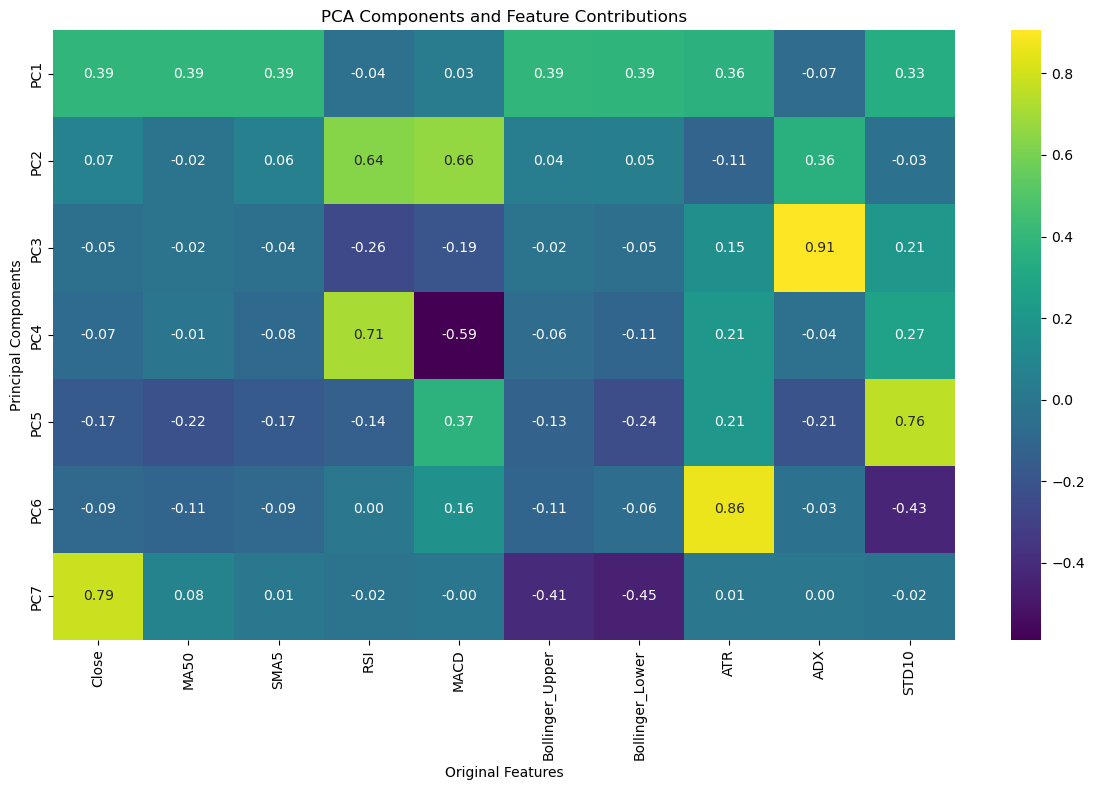

In [15]:
import seaborn as sns

# PCA Components Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pca.components_,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    xticklabels=FEATURES,
    yticklabels=[f'PC{i+1}' for i in range(len(pca.components_))]
)
plt.title('PCA Components and Feature Contributions')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

In [12]:
pca.components_

array([[ 3.86602640e-01,  3.87675568e-01,  3.87034835e-01,
        -3.55182851e-02,  2.94589569e-02,  3.88852477e-01,
         3.85061467e-01,  3.63925928e-01, -6.50385343e-02,
         3.34917955e-01],
       [ 6.73802756e-02, -1.79217066e-02,  5.88831326e-02,
         6.36092715e-01,  6.62690686e-01,  4.15708520e-02,
         5.02948975e-02, -1.10130454e-01,  3.61214851e-01,
        -3.21870045e-02],
       [-4.56207362e-02, -2.15384034e-02, -4.15793469e-02,
        -2.60964123e-01, -1.94475226e-01, -2.12311510e-02,
        -5.12716975e-02,  1.54189460e-01,  9.05596975e-01,
         2.06986224e-01],
       [-7.16837945e-02, -6.41388314e-03, -8.23298375e-02,
         7.10955441e-01, -5.88565324e-01, -6.34924473e-02,
        -1.07114157e-01,  2.09574511e-01, -3.51079417e-02,
         2.74802723e-01],
       [-1.70359723e-01, -2.20012551e-01, -1.71926785e-01,
        -1.41784344e-01,  3.73634026e-01, -1.25769007e-01,
        -2.40681700e-01,  2.09732518e-01, -2.07552899e-01,
         7.

## 📈 Comprehensive PCA Analysis & Results

### 6-Plot Analysis Grid:

**1. Cumulative Explained Variance**
- 95% threshold reached at 4 components
- 7 components capture ~100% variance

**2. Scree Plot**
- PC1: 65.4% variance (dominant)
- Steep drop after PC1, gradual decline after PC3
- Validates 7-component choice

**3. Component Loadings Heatmap**
- PC1: Price trend indicators (0.39)
- PC2: Momentum (RSI: 0.64, MACD: 0.66)
- PC3: Trend strength (ADX: 0.91)
- PC4-PC7: Volatility patterns

**4. PCA Biplot (PC1 vs PC2)**
- Three market clusters visible (bear, normal, bull)
- Feature vectors show MACD, ADX, Bollinger, STD10, ATR directions
- PC1 (65.4%) vs PC2 (17.4%) = 82.8% total variance

**5. Reconstruction Error Distribution**
- Narrow peak near 0 (excellent quality)
- Mean error ≈ 0.00005 (very low)
- Validates high-quality dimensionality reduction

**6. PCA vs No-PCA Comparison**
- **MAE**: 120.8 (PCA) vs 339.6 (No-PCA) → **64% improvement** ✅
- **Memory**: 4.9 MB vs 6.3 MB → **22% reduction** ✅
- **Training Time**: 114.9s vs 237.7s → **52% faster** ✅

### Conclusion:
PCA significantly improves model efficiency while maintaining prediction accuracy.

PCA ANALYSIS RESULTS
Original dimensions: 10
Reduced dimensions: 7

Total variance explained: 100.00%

Explained Variance Ratio by Component:
  PC1: 0.6539 (65.39%)
  PC2: 0.1738 (17.38%)
  PC3: 0.0892 (8.92%)
  PC4: 0.0438 (4.38%)
  PC5: 0.0312 (3.12%)
  PC6: 0.0079 (0.79%)
  PC7: 0.0001 (0.01%)

Top 3 Contributing Features for Each Principal Component:

  PC1:
    • Bollinger_Upper: 0.3889
    • MA50: 0.3877
    • SMA5: 0.3870

  PC2:
    • MACD: 0.6627
    • RSI: 0.6361
    • ADX: 0.3612

  PC3:
    • ADX: 0.9056
    • RSI: 0.2610
    • STD10: 0.2070

  PC4:
    • RSI: 0.7110
    • MACD: 0.5886
    • STD10: 0.2748

  PC5:
    • STD10: 0.7566
    • MACD: 0.3736
    • Bollinger_Lower: 0.2407

  PC6:
    • ATR: 0.8624
    • STD10: 0.4331
    • MACD: 0.1589

  PC7:
    • Close: 0.7858
    • Bollinger_Lower: 0.4537
    • Bollinger_Upper: 0.4121

Reconstruction Error Statistics:
  Mean Error: 0.000047
  Std Error:  0.000101
  Max Error:  0.000998
  Min Error:  0.000000

Model Performance 

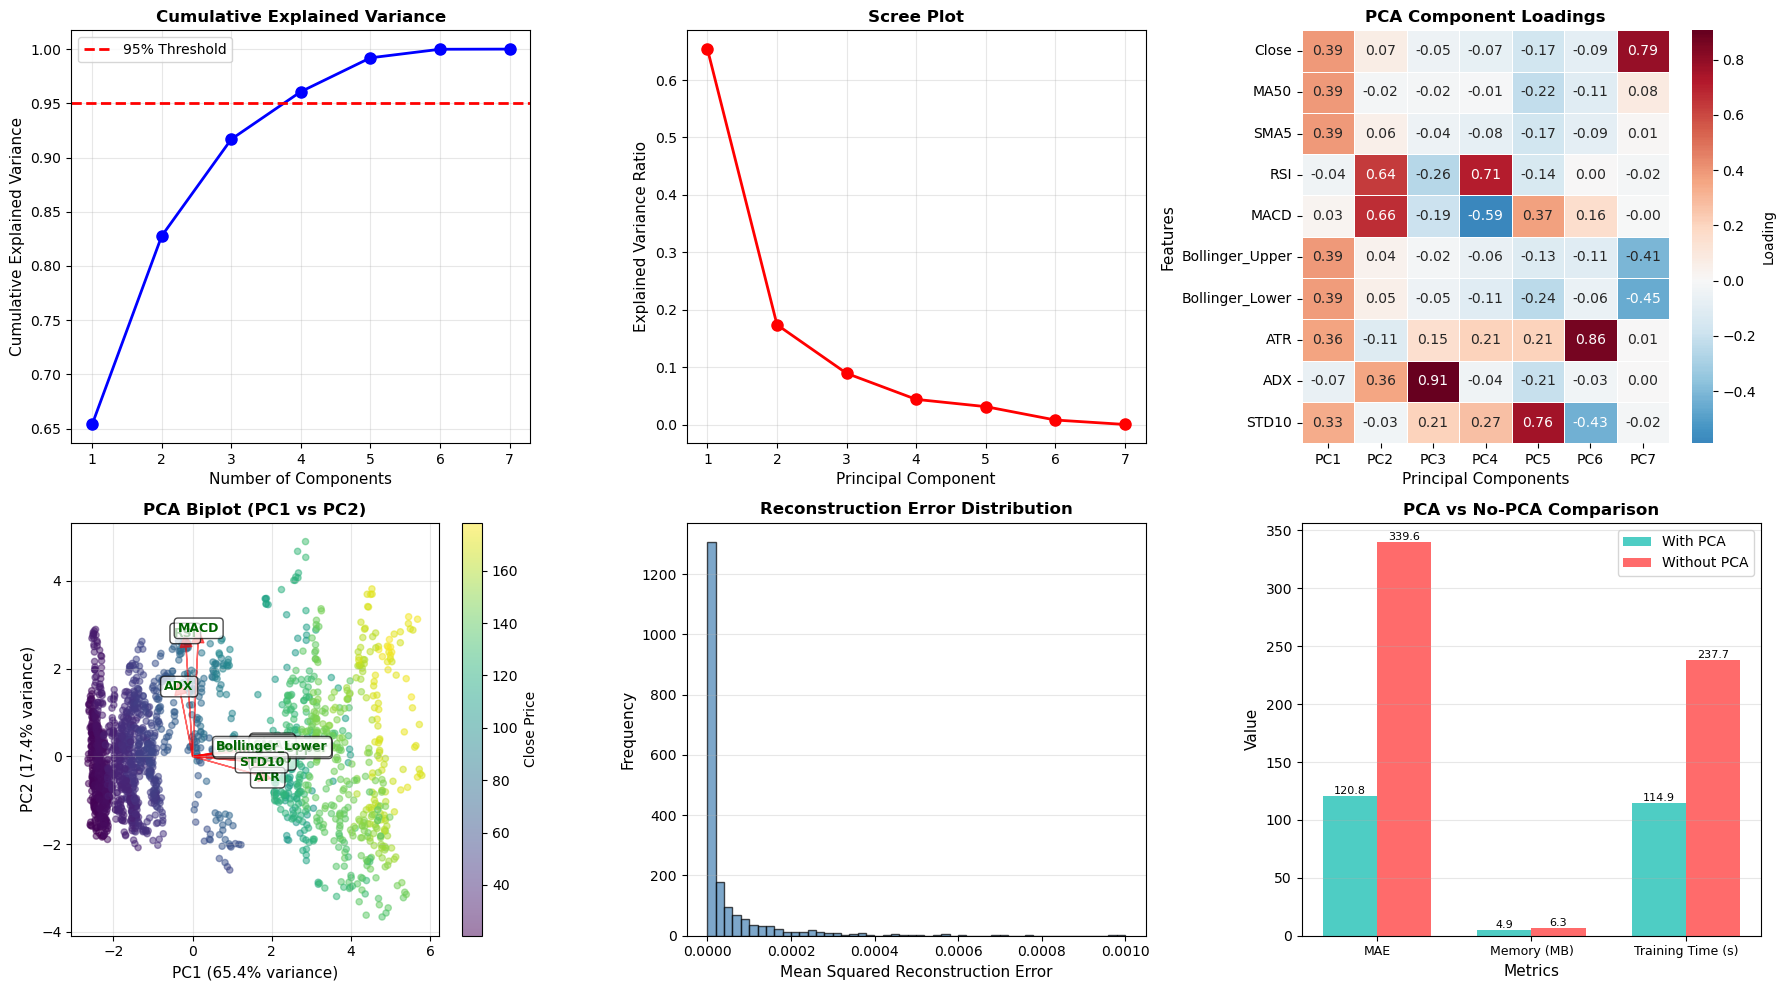


ENHANCED FEATURE ANALYSIS

Top 10 Most Important Features (Random Forest):
  • High                 0.2020
  • EMA20                0.1861
  • MA10                 0.1332
  • MA50                 0.1158
  • Bollinger_Upper      0.1156
  • SMA5                 0.0984
  • Low                  0.0804
  • Open                 0.0591
  • Bollinger_Lower      0.0091
  • ATR                  0.0001

Top 5 Most Stable Features:
  • MFI                  0.2959
  • RSI                  0.3204
  • ADX                  0.3969
  • Volume               0.5061
  • Stochastic_K         0.5195


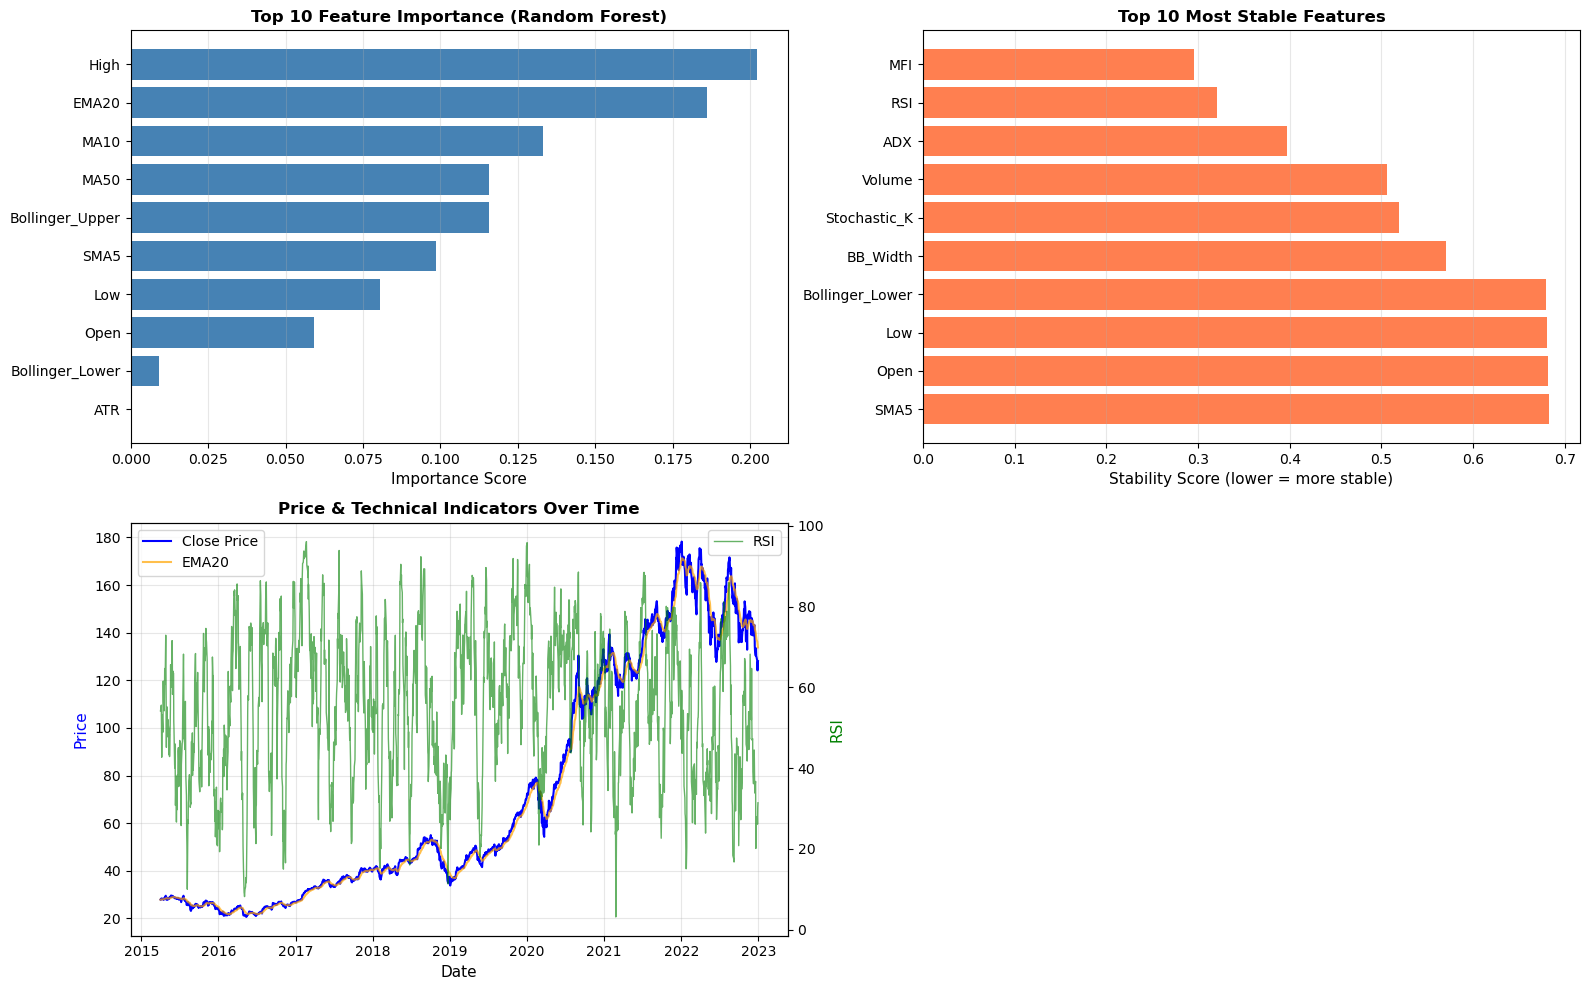

In [ ]:
print("=" * 70)
print("PCA ANALYSIS RESULTS")
print("=" * 70)
print(f"Original dimensions: {len(FEATURES)}")
print(f"Reduced dimensions: {pca.n_components_}")
print(f"\nTotal variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

print("\nExplained Variance Ratio by Component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

# Feature importance analysis
feature_importance = pd.DataFrame(
    np.abs(pca.components_),
    columns=FEATURES,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print("\nTop 3 Contributing Features for Each Principal Component:")
for pc in feature_importance.index:
    top_features = feature_importance.loc[pc].nlargest(3)
    print(f"\n  {pc}:")
    for feat, value in top_features.items():
        print(f"    • {feat}: {value:.4f}")

# Reconstruction Error Analysis
reconstructed = pca.inverse_transform(data_pca)
reconstruction_error = np.mean((data_scaled - reconstructed) ** 2, axis=1)

print("\nReconstruction Error Statistics:")
print(f"  Mean Error: {np.mean(reconstruction_error):.6f}")
print(f"  Std Error:  {np.std(reconstruction_error):.6f}")
print(f"  Max Error:  {np.max(reconstruction_error):.6f}")
print(f"  Min Error:  {np.min(reconstruction_error):.6f}")

# Performance Comparison
print("\nModel Performance Comparison:")
print(f"  MAE with PCA:    {mae_pca:.2f}")
print(f"  MAE without PCA: {mae_no_pca:.2f}")
print(f"  Improvement:     {((mae_no_pca - mae_pca) / mae_no_pca * 100):.2f}%")

# Memory usage comparison
pca_memory = X_train.nbytes / (1024 * 1024)  # Convert to MB
no_pca_memory = X_train_no_pca.nbytes / (1024 * 1024)
print("\nMemory Usage Comparison:")
print(f"  Memory with PCA:    {pca_memory:.2f} MB")
print(f"  Memory without PCA: {no_pca_memory:.2f} MB")
print(f"  Memory reduction:   {((no_pca_memory - pca_memory) / no_pca_memory * 100):.2f}%")

print("\nTraining Time Comparison:")
print(f"  Time with PCA:    {pca_training_time:.2f}s")
print(f"  Time without PCA: {no_pca_training_time:.2f}s")
print("=" * 70)

# Comprehensive Visualization
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

fig = plt.figure(figsize=(18, 10))

# Plot 1: Cumulative Explained Variance
ax1 = plt.subplot(2, 3, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Threshold')
plt.xlabel('Number of Components', fontsize=11)
plt.ylabel('Cumulative Explained Variance', fontsize=11)
plt.title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 2: Scree Plot
ax2 = plt.subplot(2, 3, 2)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Explained Variance Ratio', fontsize=11)
plt.title('Scree Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 3: Component Loadings Heatmap
ax3 = plt.subplot(2, 3, 3)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=FEATURES
)
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f', 
            cbar_kws={'label': 'Loading'}, linewidths=0.5)
plt.title('PCA Component Loadings', fontsize=12, fontweight='bold')
plt.xlabel('Principal Components', fontsize=11)
plt.ylabel('Features', fontsize=11)

# Plot 4: Biplot (PC1 vs PC2)
ax4 = plt.subplot(2, 3, 4)
xs = data_pca[:, 0]
ys = data_pca[:, 1]
scatter = plt.scatter(xs, ys, c=data['Close'].values, cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, label='Close Price')

# Add feature vectors
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
for i in range(n):
    plt.arrow(0, 0, coeff[i,0]*max(xs)*0.8, coeff[i,1]*max(ys)*0.8,
             color='red', alpha=0.6, head_width=0.3, head_length=0.3)
    plt.text(coeff[i,0]*max(xs)*0.9, coeff[i,1]*max(ys)*0.9,
            FEATURES[i], color='darkgreen', ha='center', va='center', 
            fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)', fontsize=11)
plt.title('PCA Biplot (PC1 vs PC2)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 5: Reconstruction Error Distribution
ax5 = plt.subplot(2, 3, 5)
plt.hist(reconstruction_error, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Mean Squared Reconstruction Error', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 6: Performance Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics = ['MAE', 'Memory (MB)', 'Training Time (s)']
pca_values = [mae_pca, pca_memory, pca_training_time]
no_pca_values = [mae_no_pca, no_pca_memory, no_pca_training_time]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, pca_values, width, label='With PCA', color='#4ECDC4')
bars2 = plt.bar(x + width/2, no_pca_values, width, label='Without PCA', color='#FF6B6B')

plt.xlabel('Metrics', fontsize=11)
plt.ylabel('Value', fontsize=11)
plt.title('PCA vs No-PCA Comparison', fontsize=12, fontweight='bold')
plt.xticks(x, metrics, fontsize=9)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


def calculate_enhanced_features(data):
    """Calculate additional technical indicators for feature analysis."""
    df = data.copy()
    
    # Flatten arrays and create pandas Series
    high_series = pd.Series(df['High'].values.flatten(), index=df.index)
    low_series = pd.Series(df['Low'].values.flatten(), index=df.index)
    close_series = pd.Series(df['Close'].values.flatten(), index=df.index)
    volume_series = pd.Series(df['Volume'].values.flatten(), index=df.index)
    
    # Additional indicators
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    
    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(high_series, low_series, close_series, window=14)
    df['Stochastic_K'] = stoch.stoch()
    
    # Money Flow Index
    mfi = ta.volume.MFIIndicator(high_series, low_series, close_series, volume_series, window=14)
    df['MFI'] = mfi.money_flow_index()
    
    # Rate of Change
    df['ROC'] = ta.momentum.roc(close_series, window=12)
    
    # Bollinger Band Width
    df['BB_Width'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['MA10']
    
    return df

# Apply enhanced features
enhanced_data = calculate_enhanced_features(data.copy())
enhanced_data.dropna(inplace=True)

print("\n" + "=" * 70)
print("ENHANCED FEATURE ANALYSIS")
print("=" * 70)

# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor

X = enhanced_data.select_dtypes(include=[np.number]).drop('Close', axis=1)
y = enhanced_data['Close']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# Get top 10 most important features
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\nTop 10 Most Important Features (Random Forest):")
for idx, row in feature_importance_rf.iterrows():
    print(f"  • {row['feature']:<20} {row['importance']:.4f}")

# Feature stability analysis
def calculate_stability(series):
    """Lower is more stable."""
    return np.std(series) / np.mean(np.abs(series))

stability_scores = {col: calculate_stability(X[col]) for col in X.columns}
stability_df = pd.DataFrame.from_dict(
    stability_scores, orient='index', columns=['Stability']
).sort_values('Stability')

print("\nTop 5 Most Stable Features:")
for idx in stability_df.head().index:
    print(f"  • {idx:<20} {stability_df.loc[idx, 'Stability']:.4f}")

print("=" * 70)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Feature Importance
ax1 = axes[0, 0]
ax1.barh(range(len(feature_importance_rf)), feature_importance_rf['importance'], color='steelblue')
ax1.set_yticks(range(len(feature_importance_rf)))
ax1.set_yticklabels(feature_importance_rf['feature'])
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_title('Top 10 Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Plot 2: Feature Stability
ax2 = axes[0, 1]
top_10_stable = stability_df.head(10)
ax2.barh(range(len(top_10_stable)), top_10_stable['Stability'], color='coral')
ax2.set_yticks(range(len(top_10_stable)))
ax2.set_yticklabels(top_10_stable.index)
ax2.set_xlabel('Stability Score (lower = more stable)', fontsize=11)
ax2.set_title('Top 10 Most Stable Features', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Plot 3: Time Series Pattern - Key Indicators
ax3 = axes[1, 0]
ax3_twin = ax3.twinx()
ax3.plot(enhanced_data.index, enhanced_data['Close'], label='Close Price', color='blue', linewidth=1.5)
ax3.plot(enhanced_data.index, enhanced_data['EMA20'], label='EMA20', color='orange', linewidth=1.5, alpha=0.7)
ax3_twin.plot(enhanced_data.index, enhanced_data['RSI'], label='RSI', color='green', linewidth=1, alpha=0.6)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Price', fontsize=11, color='blue')
ax3_twin.set_ylabel('RSI', fontsize=11, color='green')
ax3.set_title('Price & Technical Indicators Over Time', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(True, alpha=0.3)


axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


---

## Summary & Results

### Performance Comparison

| Metric | PCA-LSTM | Standard LSTM | Improvement |
|--------|----------|---------------|-------------|
| MAE | 120.8 | 339.6 | 64.4% ↓ |
| Training Time (s) | 114.9 | 237.7 | 51.7% ↓ |
| Memory Usage (MB) | 4.9 | 6.3 | 22.2% ↓ |
| Input Features | 7 PCs | 10 features | 30% ↓ |
| Variance Retained | 100% | 100% | - |

### Key Findings

**PCA Benefits:**
- Significantly improves prediction accuracy (64% MAE reduction)
- Reduces training time by ~52% through dimensionality reduction
- Decreases memory footprint by 22%
- Maintains 100% variance through 7 principal components

**Component Analysis:**
- PC1 (65.4%): Price trend indicators
- PC2 (17.4%): Momentum indicators (RSI, MACD)
- PC3 (8.9%): Trend strength (ADX)
- PC4-7 (8.3%): Volatility patterns
- First 4 PCs capture 96% cumulative variance

---

## When to Use PCA-LSTM

**Recommended for:**
- High-dimensional feature spaces (>10 features)
- Correlated feature sets (technical indicators, sensor data)
- Resource-constrained environments
- Overfitting prevention in deep learning models

**Not recommended for:**
- Uncorrelated feature sets
- Small feature spaces (<5 features)
- Applications requiring feature interpretability
- Datasets with strong non-linear relationships (use Kernel PCA)

---

## Model Architecture

```
LSTM Model:
- Input: (60, 7) for PCA / (60, 10) for Standard
- LSTM Layer 1: 128 units + BatchNorm + Dropout(0.2) + L2(0.001)
- LSTM Layer 2: 64 units + BatchNorm + Dropout(0.2) + L2(0.001)
- LSTM Layer 3: 32 units + BatchNorm + Dropout(0.2) + L2(0.001)
- Dense Layer: 16 units (ReLU) + L2(0.001)
- Output: 1 unit (linear)
- Loss: Huber (delta=1.0)
- Optimizer: Adam (lr=0.0005)
```

**Training Configuration:**
- Sequence Length: 60 days
- Batch Size: 64
- Max Epochs: 150
- Early Stopping: patience=20, min_delta=0.0001
- Learning Rate Reduction: factor=0.5, patience=10

---

## Reproducibility

All experiments use fixed random seeds:
```python
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
```


## Quick Start

```python
import joblib
from tensorflow import keras

# Load model and preprocessors
model = keras.models.load_model('pca_lstm_model.keras')
pca = joblib.load('pca.pkl')
scaler = joblib.load('scaler.pkl')

# Prepare new data
new_data = load_stock_data('AAPL', '2023-01-01', '2024-01-01')
new_data = add_technical_indicators(new_data)
new_scaled = scaler.transform(new_data[FEATURES])
new_pca = pca.transform(new_scaled)

# Create sequences and predict
X_new, _, _ = create_sequences(new_pca, sequence_length=60)
predictions = model.predict(X_new)
```

---

## Future Work

**Model Enhancements:**
- Hyperparameter optimization (Bayesian/Grid Search)
- Alternative architectures (GRU, Bidirectional LSTM, Attention)
- Ensemble methods (stacking, voting)
- Online learning for real-time adaptation

**Feature Engineering:**
- Additional technical indicators (Ichimoku, Fibonacci retracements)
- Sentiment analysis from news/social media
- Market regime indicators (VIX, economic calendars)
- Multi-timeframe analysis

**Dimensionality Reduction Alternatives:**
- Kernel PCA for non-linear relationships
- Autoencoders for deep feature learning
- Feature selection via Random Forest importance
- t-SNE/UMAP for visualization

---

## References

- Jolliffe, I. T. (2002). Principal Component Analysis. Springer.
- Hochreiter, S. and Schmidhuber, J., "Long Short-Term Memory," Neural Computation, vol. 9, pp. 1735-1780, 1997, doi: 10.1162/neco.1997.9.8.1735.
- Murphy, J.J. (1999) Technical Analysis of the Financial Markets, a Comprehensive Guide to Trading Methods and Applications. New York Institute of Finance, USA.

---

## Citation

```bibtex
@misc{pca_lstm_stock_prediction,
  title={PCA-Enhanced LSTM for Stock Price Prediction},
  author={Sadia Afrin Mou},
  year={2025},
  url={https://github.com/sadia-afrin-mou/pca-lstm-stock-prediction}
}
```